In [1]:
#Importing libraries
import io
import pandas as pd
import numpy as np
import keras
import plotly.express as px
import plotly.subplots 
import plotly.graph_objects as go
import seaborn as sns

In [2]:
#Dataset processing
dataset = pd.read_csv(r"D:\Documents\ML\Linear Regression\crop_yield.csv")
dataset.head(5)

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


In [3]:
#Checking if there are any missing values
missing_val = dataset.isnull().sum().sum()
print(missing_val)

0


In [4]:
#Subsetting the dataset to seperate training dataset and testing dataset
num_rows , num_cols = dataset.shape
training_row = int(num_rows * (0.75))
testing_row = num_rows - training_row
training_df = dataset.iloc[:training_row]
test_df = dataset.iloc[training_row: ]
test_df.reset_index()

,index,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,750000,West,Silt,Barley,572.037277,38.399927,True,False,Sunny,85,5.020821
1,750001,East,Sandy,Soybean,404.947940,30.694402,False,True,Rainy,81,4.341647
2,750002,East,Chalky,Cotton,477.349439,38.958514,True,False,Cloudy,116,5.074730
3,750003,North,Silt,Soybean,602.190614,35.050016,False,False,Rainy,90,3.343276
4,750004,South,Clay,Barley,541.649569,29.028135,False,False,Sunny,98,3.690702
...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,West,Silt,Rice,302.805345,27.987428,False,False,Sunny,76,1.347586
249996,999996,South,Chalky,Barley,932.991383,39.661039,True,False,Rainy,93,7.311594
249997,999997,North,Peaty,Cotton,867.362046,24.370042,True,False,Cloudy,108,5.763182
249998,999998,West,Silt,Wheat,492.812857,33.045505,False,False,Sunny,102,2.070159


In [5]:
#Finding Correlation between the dataset
training_df.corr(numeric_only=True)

,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Days_to_Harvest,Yield_tons_per_hectare
Rainfall_mm,1.000000,0.000107,-0.000766,-0.000962,-0.003067,0.764434
Temperature_Celsius,0.000107,1.000000,0.002373,0.000017,-0.000502,0.085747
Fertilizer_Used,-0.000766,0.002373,1.000000,0.000704,-0.001542,0.442475
Irrigation_Used,-0.000962,0.000017,0.000704,1.000000,-0.001090,0.353334
Days_to_Harvest,-0.003067,-0.000502,-0.001542,-0.001090,1.000000,-0.003157
Yield_tons_per_hectare,0.764434,0.085747,0.442475,0.353334,-0.003157,1.000000


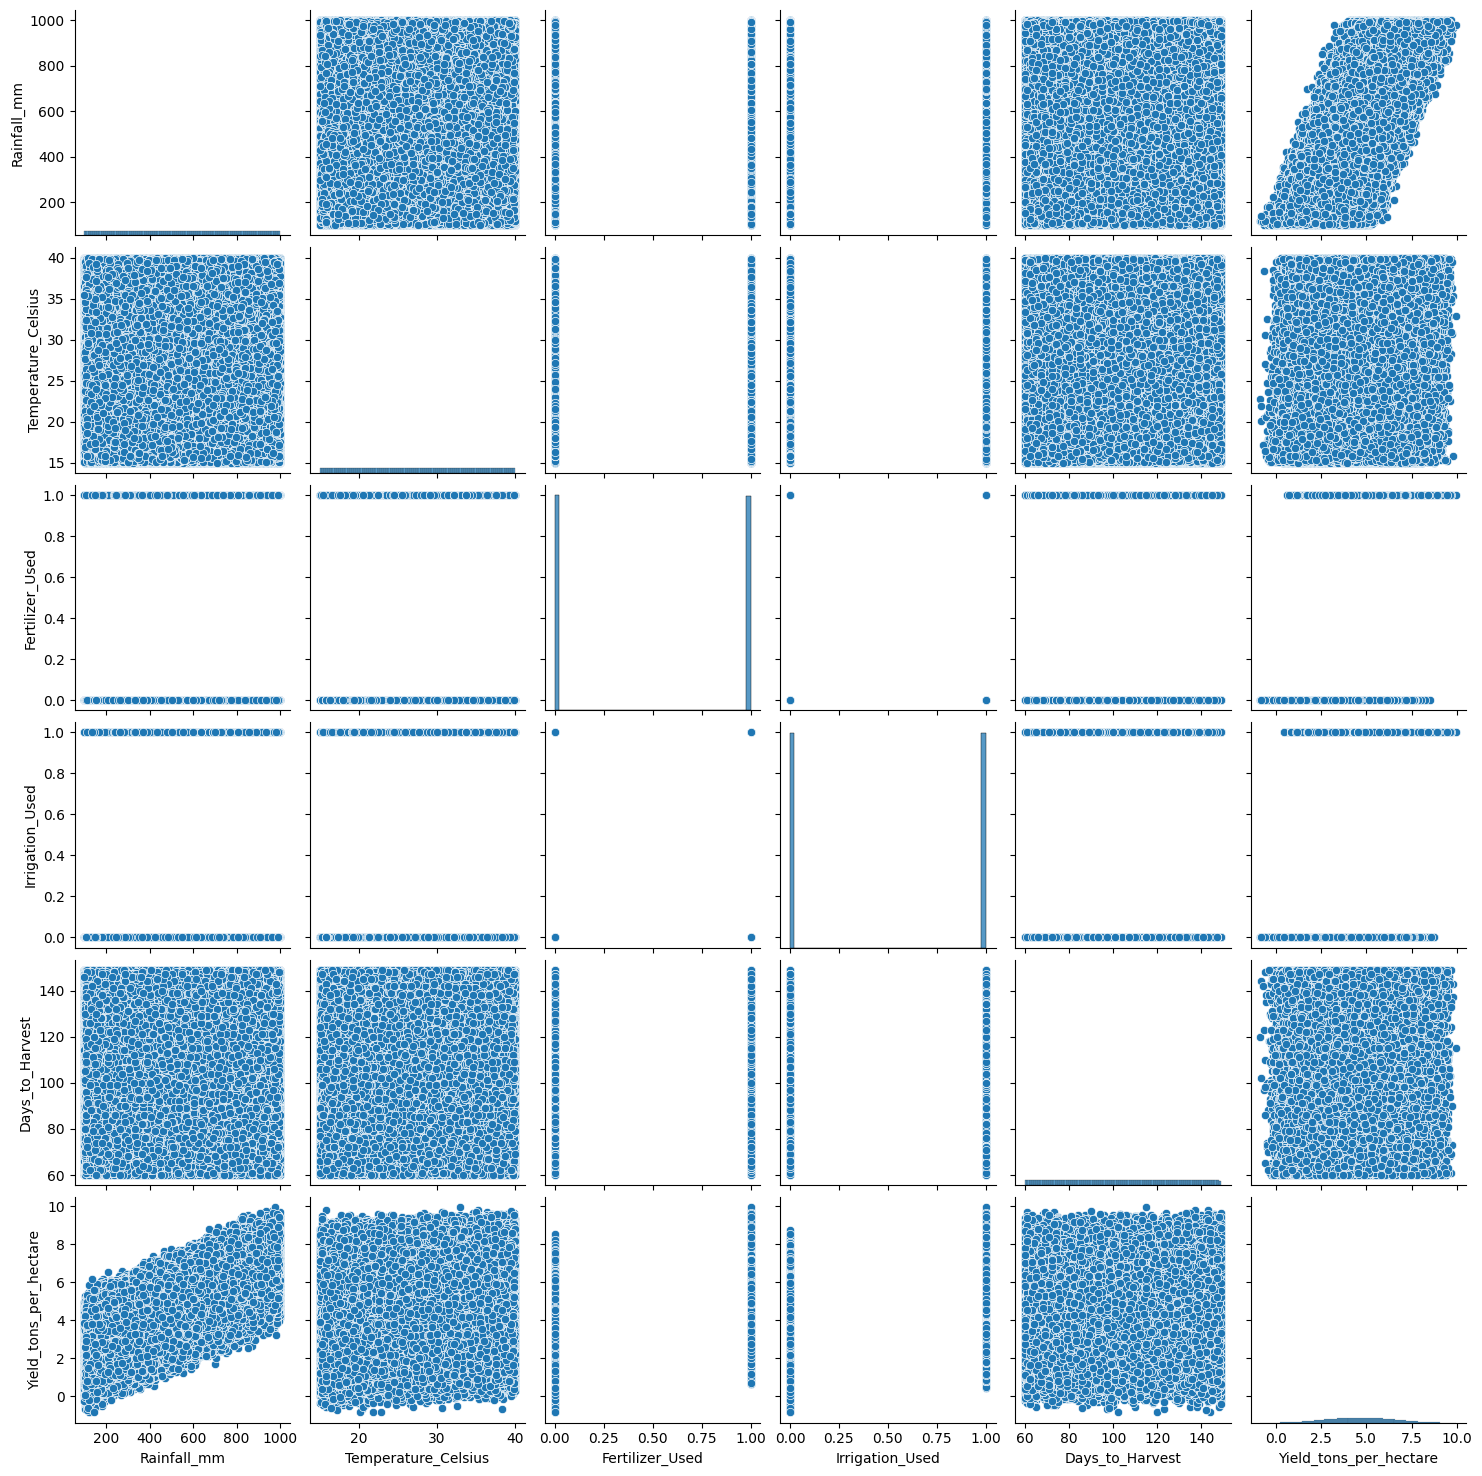

In [6]:
sns.pairplot(training_df)

<p>As observed from the pairplot and the correlation matrix, the rainfall_mm value is having strong correlation with the crop yield per hectare<br/>
Hence we will be using rainfall_mm value as the only feature for our model</p>

In [7]:
#Plotting functions for visualization of the model

def loss_curve_plot(epoch, rmse, fig):
#This funnction is used to plot the loss curve which is plot of root mean squared error ams the number of epochs
        curve = px.line(x=epoch, y=rmse)
        curve.update_traces(line_color = "#ff0000", line_width=3)
        fig.append_trace(curve.data[0], row=1, col=1)
        fig.update_xaxes(title_text="Epochs", row=1, col=1)
        fig.update_yaxes(title_text="RMSE", row=1, col=1)
        return

def plot_data(df, features, label, fig):
#This function is used to plot the overall features vs label scatter plot with the values available in the dataset
#This function only plots the points and the best fit line of the model is not drawn here
        scatter = px.scatter(df, x=features[0], y=label)
        fig.append_trace(scatter.data[0], row=1, col=2)
        fig.update_xaxes(title_text= features[0], row=1, col=1)
        fig.update_yaxes(title_text=label, row=1, col=1)
        return

def plot_model(df, features, weights, bias, fig):
#This function acually plots the best fit line according to the model for one feature
        df["yield_predicted"] = bias[0]    #acts as starting point for regression as bias is the y intercept
        for index, feature in enumerate(features):
                df["yield_predicted"] = df["yield_predicted"] + (weights[index][0] * df[feature])

        model = px.line(df, x=features[0], y=df["yield_predicted"])
        model.update_traces(line_color= "#ff0000", line_width=3)

        fig.add_trace(model.data[0], row=1, col=2)
        return

def make_plots(df, feature_names, label_name, model_op, sample_size=200):
        random_smaple = df.sample(n=sample_size).copy()
        random_smaple.reset_index()
        #The above lines help to follow the method of mini SGD for the model

        weights, bias, epochs, rmse = model_op
        fig = plotly.subplots.make_subplots(rows=1, cols=2, subplot_titles=("Loss Curve", "Model"), specs=[[{"type":"scatter"}, {"type":"scatter"}]])

        plot_data(random_smaple, feature_names, label_name , fig)
        plot_model(random_smaple, feature_names, weights, bias, fig)
        loss_curve_plot(epochs, rmse, fig)

        fig.show()
        return
        

In [8]:
#Buinding and training the model using keras library

def build_model(learning_rate):
    inputs = keras.Input(shape=(1,))
    #This function creates an input layer taking 1D array or vector as input as we have only one feature

    outputs = keras.layers.Dense(units=1)(inputs)
    #This function creates an output layer which will give only one type of data, here it will be the predicted yield

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate), loss="mean_squared_error", metrics=[keras.metrics.RootMeanSquaredError()])
    return model


def train_model(model, df, features, label, epochs, batch_size):
    history = model.fit(x=features, y=label, batch_size= batch_size, epochs=epochs)

    trained_weight = model.get_weights()[0]
    trained_bias = model.get_weights()[1]

    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    rmse = hist["root_mean_squared_error"]
    return trained_weight, trained_bias, epochs, rmse


def run_expt(df, feature_names, label_name ,learning_rate, epochs, batch_size):
    features = df.loc[: , feature_names].values
    label = df[label_name].values

    model = build_model(learning_rate)
    model_op = train_model(model, df, features, label, epochs, batch_size)
    make_plots(df, feature_names, label_name, model_op)
    return model

In [9]:
#Running the experiment to make the actual model

#Setting hyperparameters for the model
learning_rate = 0.0001
epochs = 8
batch_size = 128

#Setting the parameters of the model
features = ["Rainfall_mm"]
label = "Yield_tons_per_hectare"
# training_df = training_df[["Rainfall_mm", "Yield_tons_per_hectare"]]

model1 = run_expt(df=training_df, feature_names=features, label_name=label, learning_rate=learning_rate, epochs=epochs, batch_size=batch_size)
print("Experiment run successfully")

Epoch 1/8
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 4s 672us/step - loss: 132641.7031 - root_mean_squared_error: 361.2279
Epoch 2/8
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 4s 654us/step - loss: 2134.4932 - root_mean_squared_error: 42.9874
Epoch 3/8
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 4s 662us/step - loss: 1.9914 - root_mean_squared_error: 1.4110
Epoch 4/8
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 4s 640us/step - loss: 1.6337 - root_mean_squared_error: 1.2781
Epoch 5/8
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 4s 649us/step - loss: 1.3951 - root_mean_squared_error: 1.1811
Epoch 6/8
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 4s 655us/step - loss: 1.2626 - root_mean_squared_error: 1.1236
Epoch 7/8
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 4s 647us/step - loss: 1.2148 - root_mean_squared_error: 1.1022
Epoch 8/8
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 4s 644us/step - loss: 1.2021 - root_mean_squared_error: 1.0964


Experiment run successfully


In [15]:
#Model validation
predicted_val = (model1.predict_on_batch(x=test_df.loc[:, features].values)).astype("float")
predicted_val_lst = []

for i in range(len(predicted_val)):
    predicted_val_lst.append(float(predicted_val[i][0]))

comparison_df = test_df[["Rainfall_mm", "Yield_tons_per_hectare"]].copy()
comparison_df["Predicted Yield"] = predicted_val_lst
comparison_df.reset_index(0)
comparison_df.head(10)

,Rainfall_mm,Yield_tons_per_hectare,Predicted Yield
750000,572.037277,5.020821,4.844140
750001,404.947940,4.341647,3.969801
750002,477.349439,5.074730,4.348661
750003,602.190614,3.343276,5.001925
750004,541.649569,3.690702,4.685128
750005,621.760065,6.134888,5.104327
750006,801.267932,6.836465,6.043649
750007,381.103897,5.449707,3.845031
750008,391.161352,3.115133,3.897660
750009,393.348247,4.805628,3.909103


<p>Hence, as observed from the above table, the prediced value of yield is close to the actual value of yield</p>